# 数据生成

AERO-Suite里的**AERO-F**是流体仿真模拟器，这里是详细的[**AERO-F**教程](https://bitbucket.org/frg/aero-f/downloads/AERO-F.pdf)。
**AERO-S**是固体仿真模拟器，这里是详细的[**AERO-S**教程](https://bitbucket.org/frg/aero-s/downloads/AERO-S.pdf)。

本案例是使用AERO-Suite生成大量稳态机翼数据用于训练神经算子。分为以下几个步骤
- 参数化机翼（airfoil）和其襟翼（flap）, 生成相关的 `.geo` 文件，采用**gmsh**生成流体网格
- 使用**AERO-Suite**仿真计算结果
- 处理计算结果，去掉没有收敛的结果

# 生成网格进行仿真

我们采用4位数NACA翼型，对主机翼和襟翼进行参数化，主机翼弦长为1，襟翼弦长为0.2， 
参数包括主机翼的弯弧量 （最大弯度占翼弦长的比例） $0 \leq m \leq 0.09$， 最大弯度位置 （最大弯度点距前缘的距离占翼弦长的比例） $0.2 \leq p \leq 0.6$，厚度 （最大厚度占翼弦长的比例） $0 \leq t \leq 0.09$， 以及迎角 $-5\leq \theta\leq 20$。 和襟翼的弯弧量 $0 \leq m_f \leq 0.09$， 最大弯度位置 $0.2 \leq p_f \leq 0.6$，厚度 $0.1 \leq t_f \leq 0.2$， 以及与主机翼的相对迎角 $5\leq \theta_f\leq 40$。
我们的参数化函数在文件 [naca_four_digit_airfoil.py](Mesh/naca_four_digit_airfoil.py) 和[gmsh_geo_generator.py](Mesh/gmsh_geo_generator.py) 中。运行这些文件中的函数`naca_flap_fluid_mesh()` 能生成流体对应的`.geo` 文件，包括了各种边界的标注。随后我们能用**gmsh**生成流体网格，然后使用**AERO-Suite**仿真计算结果。

对于生成数据，我们用**python**把 `Airfoil` 文件夹复制为 `Airfoil_XXXXX`， 提交脚本生成网格、调用**AERO-Suite**进行计算。这可以在 `Airfoil_Data` 文件夹里用以下命令行完成

```shell
sbatch Sbatch.Generate_Data.sh 
```

# 处理计算结果

我们读入**AERO-Suite**仿真计算结果，并用 [top_reader.py](Mesh/top_reader.py) 里的 `fluid_data()` 函数，处理数据得到，格点坐标 (`nodes_XXXXX.npy`)，三角形有限元 (`elems_XXXXX.npy`)，以及流体压强、马赫数等 (`features_XXXXX.npy`)，把这些数据存储下来。同样也能只保留机翼上的点把对应的数据存储下来。这可以在 `Airfoil_Data` 文件夹里用以下命令行完成

```shell
sbatch Sbatch.Postprocess_Data.sh 
```

值得注意，这里我们仅保留了**AERO-Suite**仿真计算收敛到$10^{-7}$的结果。

## 流体压强

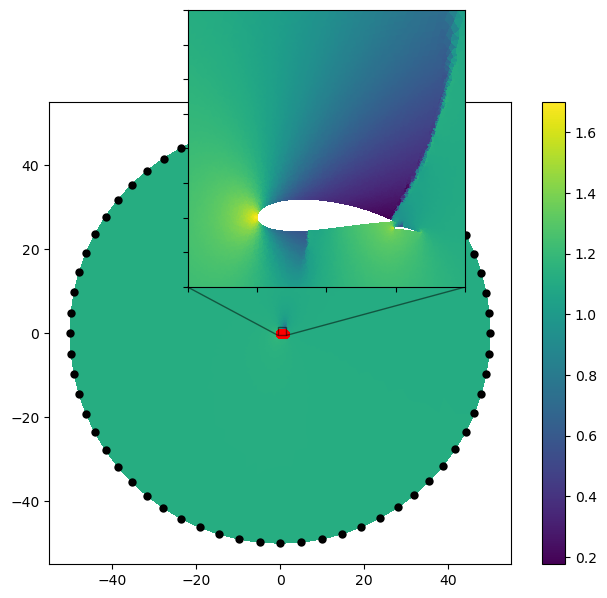

In [8]:
# For fluid data, there nodes_XXXXX.npy, elems_XXXXX.npy, features_XXXXX.npy
# nodes_XXXXX.npy contains x, y coordinate
# elems_XXXXX.npy contains e1, e2, e3, triangular nodal index (starting with 0)
# features_XXXXX.npy, contains p, mach, indicator, pressure, mach number, and indicator
# for the indicator, 0: interior node, 1: airfoil node, 2: farfield node

import numpy as np
import matplotlib.pyplot as plt 


index = 0
nodes = np.load("Airfoil_flap_data/fluid_mesh/nodes_%05d.npy" %(index))
elems = np.load("Airfoil_flap_data/fluid_mesh/elems_%05d.npy" %(index))
features = np.load("Airfoil_flap_data/fluid_mesh/features_%05d.npy" %(index))


fig, ax = plt.subplots(1, 1, figsize=(8,6))
ax.set_aspect('equal')
tpc = ax.tripcolor(nodes[:,0], nodes[:,1], features[:,0], triangles = elems, shading='flat');
ax.scatter(nodes[features[:,2]==1, 0], nodes[features[:,2]==1, 1], color="red", linewidths=0.01);
ax.scatter(nodes[features[:,2]==2, 0], nodes[features[:,2]==2, 1], color="black", linewidths=0.01);
fig.colorbar(tpc, ax=ax)
    
# inset Axes....
x1, x2, y1, y2 = -0.5, 1.5, -0.5, 1.5  # subregion of the original image
axins = ax.inset_axes(
    [0.3, 0.6, 0.6, 0.6],
    xlim=(x1, x2), ylim=(y1, y2), xticklabels=[], yticklabels=[]);
axins.tripcolor(nodes[:,0], nodes[:,1], features[:,0], triangles = elems, shading='flat');

ax.indicate_inset_zoom(axins, edgecolor="black");

## 机翼表面压强

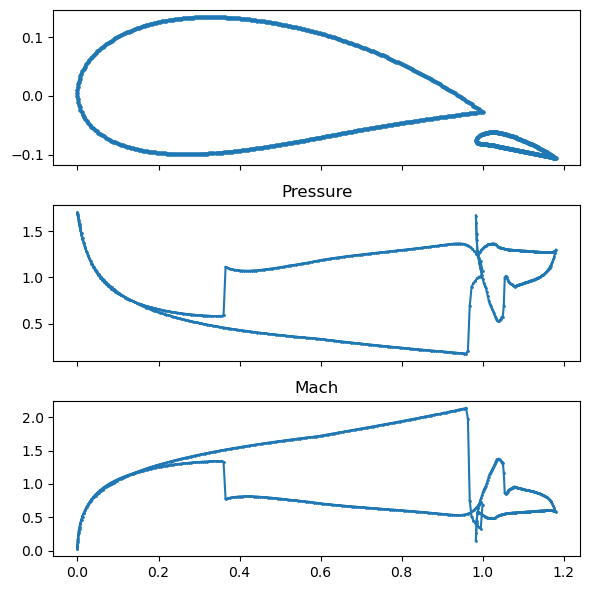

In [10]:
# For airfoil data, there nodes_XXXXX.npy, elems_XXXXX.npy, features_XXXXX.npy
# nodes_XXXXX.npy contains x, y coordinate
# elems_XXXXX.npy contains e1, e2, segment nodal index (starting with 0)
# features_XXXXX.npy, contains p, mach, indicator, pressure, mach number, and indicator
# for the indicator, 0: interior node, 1: airfoil node, 2: farfield node

index = 0
nodes = np.load("Airfoil_flap_data/airfoil_mesh/nodes_%05d.npy" %(index))
elems = np.load("Airfoil_flap_data/airfoil_mesh/elems_%05d.npy" %(index))
features = np.load("Airfoil_flap_data/airfoil_mesh/features_%05d.npy" %(index))

fig, axs = plt.subplots(3, 1, figsize=(6,6), sharex=True)
airfoil = nodes[elems, :] 
# segment k is airfoil[k, 0, :]-[k, 1, :]
axs[0].plot(airfoil[:,:,0].T, airfoil[:,:,1].T, "-o", color="C0", markersize=2)

airfoil_pressure, airfoil_mach, = features[:,0], features[:,1]
# segment k is airfoil[k, 0, :]-[k, 1, :]
axs[1].scatter(nodes[:,0], airfoil_pressure, color="C0", s=1)
axs[1].plot(airfoil[:,:,0].T, airfoil_pressure[elems].T, color="C0")
axs[1].set_title("Pressure")
axs[2].scatter(nodes[:,0], airfoil_mach, color="C0", s=1)
axs[2].plot(airfoil[:,:,0].T, airfoil_mach[elems].T, color="C0")
axs[2].set_title("Mach")
plt.tight_layout()
plt.show()